과거의 자전거 사용 패턴과 날씨 데이터를 결합하여 자전거 수요를 예측하는 문제  
https://www.kaggle.com/competitions/bike-sharing-demand/overview
2년간의 시간별 임대 데이터가 제공되며 이번 대회의 훈련 세트는 매월 19일까지, 테스트 세트는 20일부터 말일까지로 구성된다. 
임대 기간 이전에 사용 가능한 정보만 사용하여 테스트 세트에 포함된 각 시간 동안 임대된 자전거의 총 수를 예측해야한다.

datetime, weather(1-4), 휴일, 근무일, 날씨(1-4), 온도(섭씨), 체감온도, 습도, 풍속, 일반(미등록 사용자), 등록(등록사용자), 카운트(총합)


# 순서
1. train, test 데이터 세트 파악
2. 전처리 및 시각화
3. 모델 학습하여 회귀모델 적용
4. 결과 데이터 생성

In [49]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import calendar
from datetime import datetime

train_df = pd.read_csv('../data/bike_train.csv')
test_df = pd.read_csv('../data/bike_test.csv')

print(train_df.head(10))
print(test_df.head(5))
print(train_df.info())
print(test_df.info())
# 구해야 하는 것은 총 합(count)이다.

              datetime  season  holiday  workingday  weather   temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1   9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1   9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1   9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1   9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1   9.84  14.395   
5  2011-01-01 05:00:00       1        0           0        2   9.84  12.880   
6  2011-01-01 06:00:00       1        0           0        1   9.02  13.635   
7  2011-01-01 07:00:00       1        0           0        1   8.20  12.880   
8  2011-01-01 08:00:00       1        0           0        1   9.84  14.395   
9  2011-01-01 09:00:00       1        0           0        1  13.12  17.425   

   humidity  windspeed  casual  registered  count  
0        81     0.0000       3          13     16  
1        80     0.0000    

In [50]:
# object to int
# datetime -> year, month, day, time
# 2011-01-20 00:00:00
train_df['tempdate'] = train_df.datetime.apply(lambda x:x.split(' '))
train_df['tempdate']

0        [2011-01-01, 00:00:00]
1        [2011-01-01, 01:00:00]
2        [2011-01-01, 02:00:00]
3        [2011-01-01, 03:00:00]
4        [2011-01-01, 04:00:00]
                  ...          
10881    [2012-12-19, 19:00:00]
10882    [2012-12-19, 20:00:00]
10883    [2012-12-19, 21:00:00]
10884    [2012-12-19, 22:00:00]
10885    [2012-12-19, 23:00:00]
Name: tempdate, Length: 10886, dtype: object

In [51]:
train_df['year'] = train_df['tempdate'].apply(lambda x:x[0].split('-')[0])
train_df['month'] = train_df['tempdate'].apply(lambda x:x[0].split('-')[1])
train_df['date'] = train_df['tempdate'].apply(lambda x:x[0].split('-')[2])
train_df['time'] = train_df['tempdate'].apply(lambda x:x[1].split(':')[0])
train_df = train_df.drop(['tempdate', 'datetime', 'day'], axis=1)

KeyError: "['day'] not found in axis"

In [53]:
test_df['tempdate'] = test_df['datetime'].apply(lambda x:x.split(' '))

In [54]:
test_df['year'] = test_df['tempdate'].apply(lambda x:x[0].split('-')[0])
test_df['month'] = test_df['tempdate'].apply(lambda x:x[0].split('-')[1])
test_df['date'] = test_df['tempdate'].apply(lambda x:x[0].split('-')[2])
test_df['time'] = test_df['tempdate'].apply(lambda x:x[1].split(':')[0])

In [55]:
test_df = test_df.drop('tempdate', axis=1)
test_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,date,time
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,01,20,00
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,01,20,01
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,01,20,02
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,01,20,03
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,01,20,04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,2012,12,31,19
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,2012,12,31,20
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,2012,12,31,21
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,2012,12,31,22


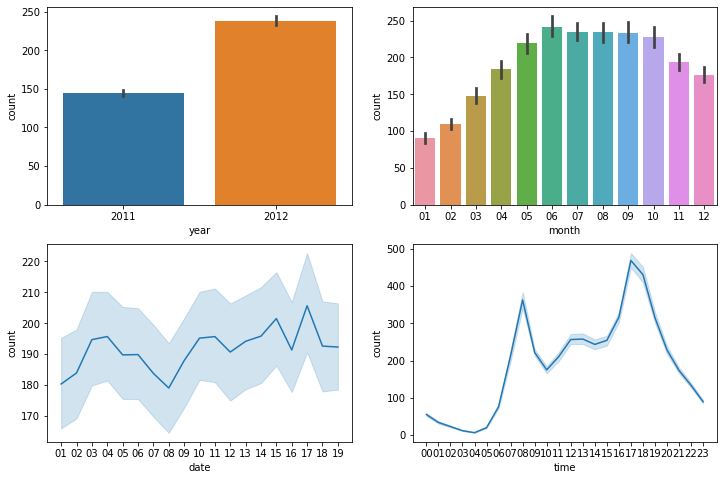

In [56]:
fig = plt.figure(figsize=[12,8])
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.barplot(x='year', y='count', data=train_df)
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.barplot(x='month', y='count', data=train_df)
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.lineplot(x='date', y='count', data=train_df)
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.lineplot(x='time', y='count', data=train_df)

plt.show()

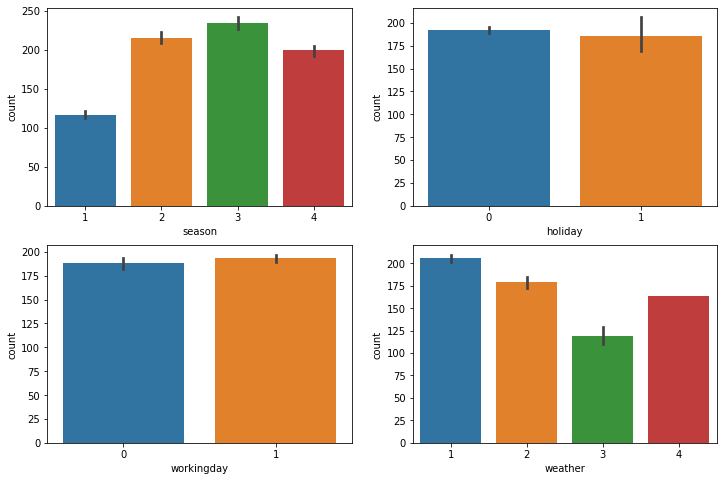

In [40]:
fig = plt.figure(figsize=[12,8])
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.barplot(x='season', y='count', data=train_df)
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.barplot(x='holiday', y='count', data=train_df)
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.barplot(x='workingday', y='count', data=train_df)
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.barplot(x='weather', y='count', data=train_df)

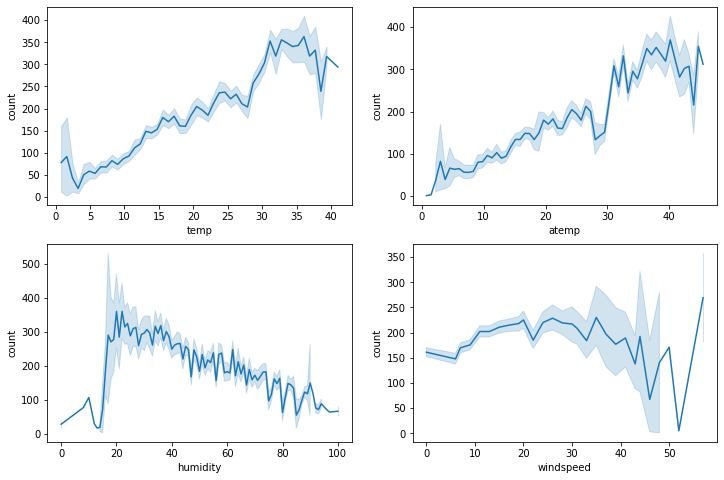

In [57]:
fig = plt.figure(figsize=[12,8])
ax1 = fig.add_subplot(2,2,1)
ax1 = sns.lineplot(x='temp', y='count', data=train_df)
ax2 = fig.add_subplot(2,2,2)
ax2 = sns.lineplot(x='atemp', y='count', data=train_df)
ax3 = fig.add_subplot(2,2,3)
ax3 = sns.lineplot(x='humidity', y='count', data=train_df)
ax4 = fig.add_subplot(2,2,4)
ax4 = sns.lineplot(x='windspeed', y='count', data=train_df)



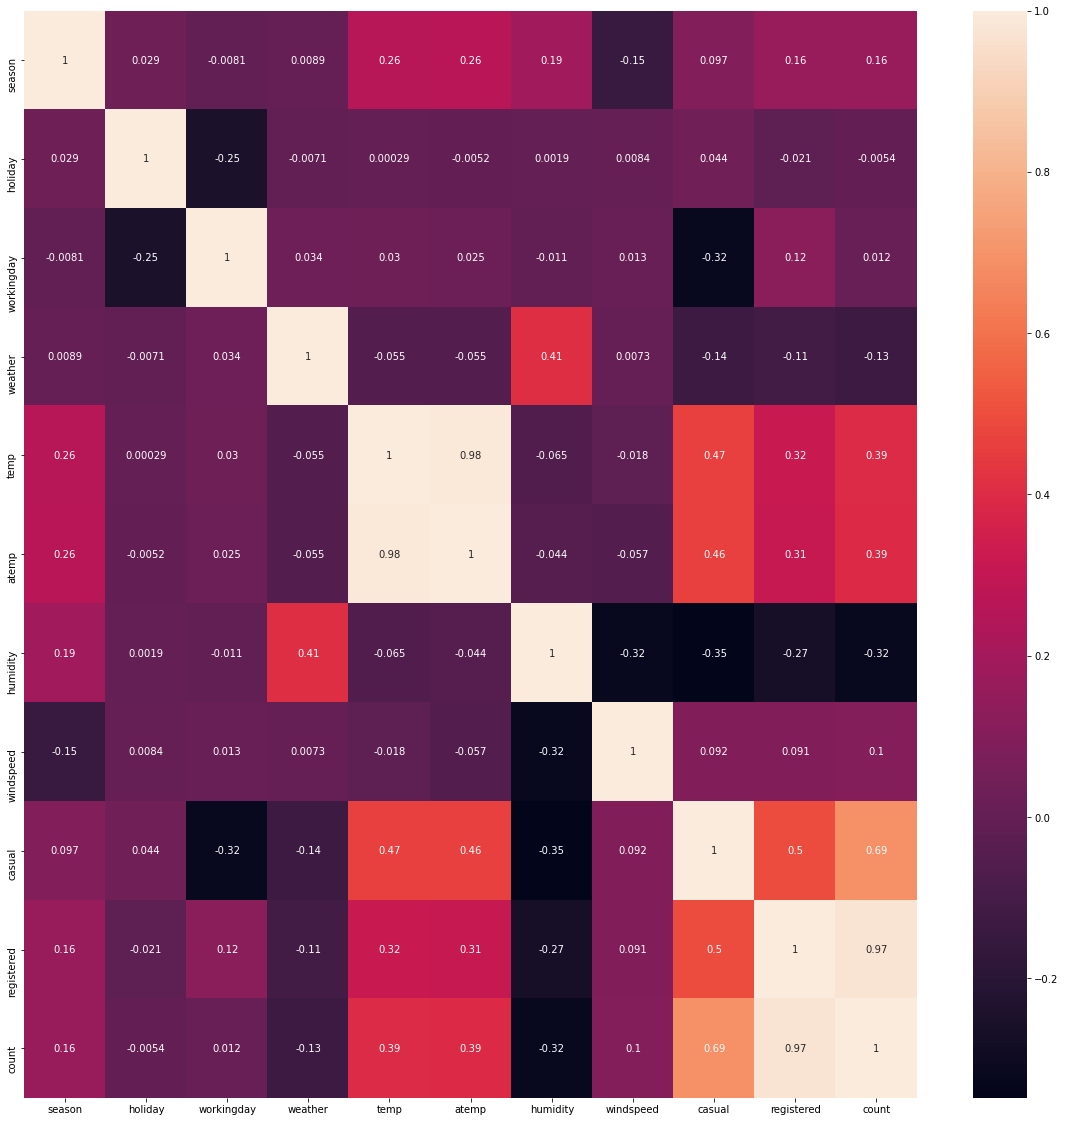

In [48]:
fig = plt.figure(figsize=[20, 20])
ax = sns.heatmap(train_df.corr(), annot=True)

데이터 준비 완료
사용할 features - > year month date time season weather temp humidity
1. 랜덤포레스트
2. 선형회귀

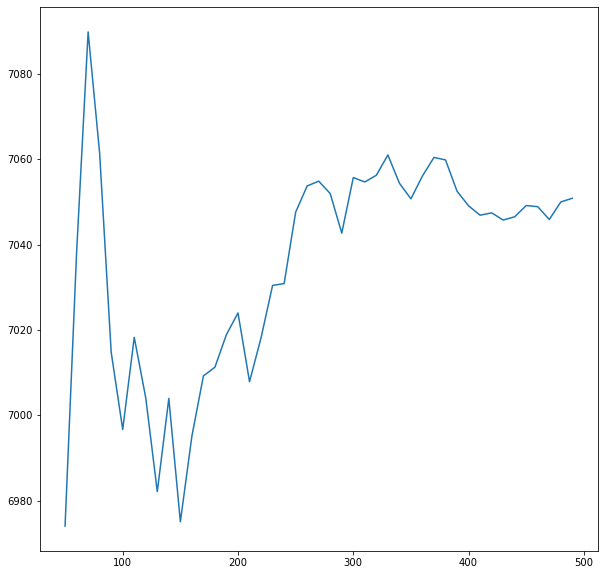

[0.08279731 0.0562178  0.05887797 0.51374517 0.02696185 0.02194751
 0.14161669 0.0978357 ]


In [71]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

train, test = train_test_split(train_df, train_size=0.8)
features = ['year', 'month', 'date', 'time','season', 'weather','temp','humidity']
train_x = train[features]
train_y = train['count']
test_x = test[features]
test_y = test['count']

scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.fit_transform(test_x)

mse = []
for i in range(50,500,10):
    rfmodel = RandomForestRegressor(n_estimators=i, max_features=4, random_state=531)
    rfmodel.fit(train_x, train_y)
    prediction = rfmodel.predict(test_x)
    mse.append(mean_squared_error(test_y, prediction))

fig = plt.figure(figsize=[10,10])
ax = sns.lineplot(x=range(50,500,10), y=mse)
plt.show()
    
featureImportance = rfmodel.feature_importances_
print(featureImportance)


7050.846961606142


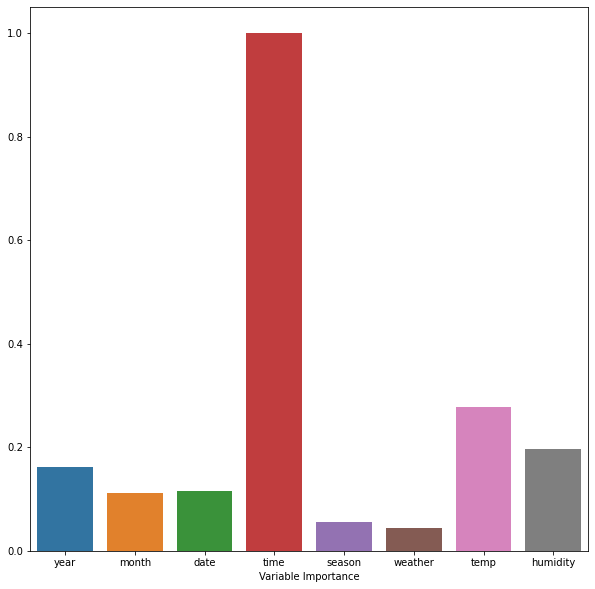

In [72]:
rfmodel = RandomForestRegressor(n_estimators=150, max_features=4, random_state=531)
rfmodel.fit(train_x, train_y)
print(mean_squared_error(test_y, prediction))

featureImportance = rfmodel.feature_importances_
featureImportance = featureImportance/featureImportance.max()
fig = plt.figure(figsize=[10,10])
ax = sns.barplot(x=features, y=featureImportance)
plt.xlabel('Variable Importance')
plt.show()

In [78]:
print(rfmodel.score(train_x, train_y))
print(rfmodel.score(test_x, test_y))

0.9763793024871422
0.782164068158531


In [83]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


train,test = train_test_split(train_df, train_size=0.8)
features = ['year', 'month', 'date', 'time','season', 'weather','temp','humidity']
train_x = train[features]
train_y = train['count']
test_x = test[features]
test_y = test['count']

scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.fit_transform(test_x)

lrmodel = LinearRegression()
lrmodel.fit(train_x, train_y)
y_prediction = lrmodel.predict(test_x)
print('mse: ', mean_squared_error(test_y, y_prediction))
print('model train accuracy: ', lrmodel.score(train_x, train_y))
print('model test accuracy: ', lrmodel.score(test_x, test_y))
print('model coef: ', lrmodel.coef_)

mse:  20931.210400000844
model train accuracy:  0.3909346769001639
model test accuracy:  0.37298151113440714
model coef:  [  82.93291077  114.35245515    7.68628634  184.42170982  -28.43679396
  -12.13667588  255.3917731  -205.79024545]


선형회귀모델보다 랜덤포레스트 모델이 훨씬 정확도가 높다. 
그렇다면 랜덤포레스트 모델로 결과 데이터를 만들어보자.

In [84]:
test_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,date,time
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,01,20,00
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,01,20,01
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,01,20,02
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,01,20,03
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,01,20,04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,2012,12,31,19
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,2012,12,31,20
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,2012,12,31,21
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,2012,12,31,22


In [91]:
input_data = test_df[features]
test_df['count'] = rfmodel.predict(input_data)
test_df = test_df.astype({'count':'int'})

In [92]:
result_df = test_df[['datetime', 'count']]

In [93]:
result_df.to_csv("./bike_result.csv", se)

,datetime,count
0,2011-01-20 00:00:00,66
1,2011-01-20 01:00:00,157
2,2011-01-20 02:00:00,157
3,2011-01-20 03:00:00,157
4,2011-01-20 04:00:00,157
...,...,...
6488,2012-12-31 19:00:00,157
6489,2012-12-31 20:00:00,157
6490,2012-12-31 21:00:00,157
6491,2012-12-31 22:00:00,157
